# **MDPs**

En primer lugar instalamos e importamos las librerías que vamos a utilizar:

In [ ]:
!pip install gymnasium pygame
!pip install imageio

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

### Creación del entorno

Utilizaremos el entorno de **Gymnasium** Frozen Lake ([descripción completa del entorno y de su funcionamiento](https://https://gymnasium.farama.org/environments/toy_text/frozen_lake/)). El objetivo del jugador será caminar a través de un lago helado desde el punto de salida hasta la meta sin caer en ningún agujero en el hielo. Si el suelo es resbaladizo, puede que el jugador no se mueva siempre en la dirección intencionada.

Crea el entorno `'FrozenLake-v1'` con argumentos `is_slippery=False ` y `render_mode='rgb_array'` para su visualización en formato imagen.

In [ ]:

env = gym.make('FrozenLake-v1', is_slippery=False,render_mode="rgb_array")

### Visualización del entorno

Después de crear el entorno, ejecuta `env.reset()` para obtener la primera observación del entorno.

In [ ]:
state, _ = env.reset()

Visualiza el entorno con `env.render()`

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
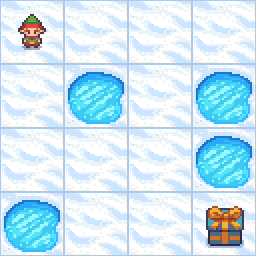

In [ ]:
env.render()

### Observation space & Action space

Averigua qué tipo de espacio de observación y de acción tiene el entorno `Frozen Lake`. Obtén información acerca del número de estados y número de acciones posibles del entorno.

In [ ]:
print(env.observation_space)

print(env.action_space)

Discrete(16)
Discrete(4)


### Ejercicio: Cálculo del retorno $G_{t}$

Se da una política determinista

La política es una matriz de tamaño `(número_de_estados, número_de_acciones)`. Cada fila representa un estado del entorno y cada columna la probabilidad, en dicho estado, de tomar cada una de las acciones posibles del espacio de acciones del entorno (en nuestro caso estas acciones son arriba, abajo, izquierda y derecha).

In [ ]:
policy = np.zeros((env.observation_space.n, env.action_space.n))
policy[0, 1]  = 1.0
policy[4, 1]  = 1.0
policy[8, 2]  = 1.0
policy[9, 2]  = 1.0
policy[10, 1] = 1.0
policy[14, 2] = 1.0
print(policy)

[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


La fórmula para calcular el retorno $G_{t}$ es:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots
     = \sum_{k=0}^{\infty} \gamma^k \, R_{t+1+k}
$$

Genera un episodio que siga la política dada `policy`, guardando la trayectoria de *(estados, acciones, recompensas)* y calcula el retorno $G_{t}$ en cada paso de tiempo $t$.

Utiliza factor de descuento $γ = 0.99$

Pista: Recorriendo el episodio al revés $G$ se puede actualizar de forma sencilla como: $G_{t} \;\leftarrow\; \gamma \, G_{t+1} + R_{t+1}$

In [ ]:
def run_episode():
    # Resetear el entorno para obtener el estado inicial
    state, _ = env.reset()
    trajectory =[]
    done=False

    while not done:
      action=np.argmax(policy[state])
      next_state, reward, terminated, truncated, _ = env.step(action)
      # El episodio habrá terminado si así lo indican terminated o truncated
      done = terminated or truncated
      # Actualizamos la variable estado al nuevo
      trajectory.append((state,action,reward))
      state = next_state
    return trajectory

In [ ]:
def compute_returns(trajectory, gamma):
    sol=[]
    G=0
    for state,action,reward in reversed(trajectory):
      G=(gamma*G) + reward
      sol.append(G)
    return list(reversed(sol))

El siguiente código genera un gráfico a partir de los retornos calculados con la función `compute_returns` para distintos valores de $γ$. Observa cómo afecta el valor de $\gamma$ a la evolución del retorno $G$ en el tiempo.

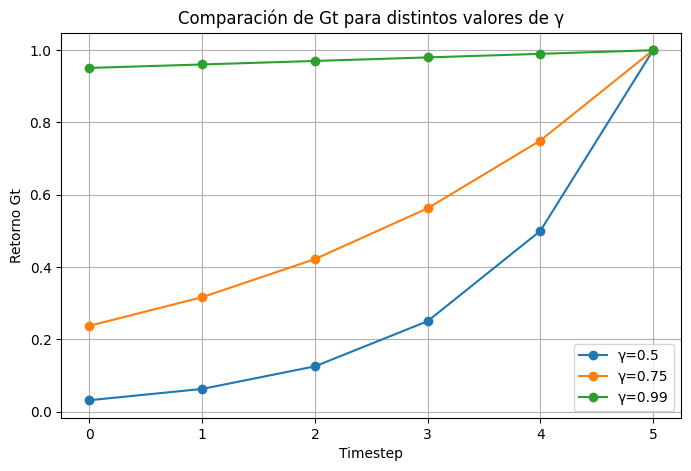

In [ ]:
gammas = [0.5, 0.75, 0.99]
plt.figure(figsize=(8,5))

for gamma in gammas:
    G = compute_returns(run_episode(), gamma)
    plt.plot(range(len(G)), G, marker="o", label=f"γ={gamma}")

plt.xlabel("Timestep")
plt.ylabel("Retorno Gt")
plt.title("Comparación de Gt para distintos valores de γ")
plt.legend()
plt.grid(True)
plt.show()

### Creación de una animación

Podemos crear una animación para visualizar las acciones del agente en el entorno según la política determinista `policy` generando un episodio que guarde cada uno de los frames y creando después una animación con Matplotlib.

In [ ]:
state, _ = env.reset()
frames = []

# Generación del episodio
for _ in range(50):
    # Obtenemos la imagen (frame) del estado actual
    frame = env.render()
    frames.append(frame)

    # Escogemos la acción óptima para el estado actual según la política
    action = np.argmax(policy[state])
    print(f"Estado: {state}, Acción: {action}")
    # Ejecutamos este paso en el entorno
    state, reward, terminated, truncated, info = env.step(action)

    # Si se ha alcanzado la meta detenemos el proceso
    done = terminated or truncated
    if done:
        frame = env.render()
        frames.append(frame)
        break

# Creación de la animación
fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=500, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

Estado: 0, Acción: 1
Estado: 4, Acción: 1
Estado: 8, Acción: 2
Estado: 9, Acción: 2
Estado: 10, Acción: 1
Estado: 14, Acción: 2


También podemos guardar esta animación en formato gif.

In [ ]:
import imageio
imageio.mimsave('trayectoria_FrozenLake.gif', frames, duration=1.0)

Cierra el entorno:

In [ ]:
env.close()

### Env.P

`Env.P` es un listado de todas las posibles transiciones que pueden ocurrir si tomas la acción `a` desde el estado `s`. Es un diccionario que contiene información sobre las probabilidades de transición para cada estado y acción en el entorno.

 `Env.P[s][a]` accede a las transiciones asociadas a una acción `a` en el estado `s`.
`env.P[s][a]` contiene es una lista de tuplas. Cada tupla tiene la forma `(probabilidad_de_transición, siguiente_estado, recompensa, hecho)`, que se refiere a:

- `transition_probability`: la probabilidad de que se produzca esa transición específica del estado `s` al estado `s'`tomando la acción `a`.

- `next_state`: el estado `s'` al que se transita después de realizar la acción `a` en el estado `s`.

- `reward`: la recompensa que se recibe al transitar del estado `s` al estado `s'` tomando la acción` a`.

- `done`: un booleano que indica si el entorno ha llegado a un estado terminal (es decir, si el episodio ha terminado).

Para poder acceder a `Env.P` en el entorno `Frozen Lake` necesitamos eliminar los wrappers que utiliza por defecto ejecutando `env = env.unwrapped`.

> Un wrapper es una forma de modificar o extender el comportamiento de un entorno sin modificar su código base directamente. Los wrappers permiten agregar funcionalidades adicionales o modificar el entorno original de manera flexible y reutilizable. En Gymnasium un wrapper es una clase que envuelve a un entorno para modificar o mejorar su comportamiento de alguna manera. La mayoría de los entornos generados vía `gym.make()` utilizan algún wrapper por defecto.

El entorno Frozen Lake utiliza por defecto el wrapper `TimeLimit`, que establece un límite de tiempo en el entorno de forma que si el agente no alcanza un estado terminal en ese tiempo, el episodio termina automáticamente.



Creamos de nuevo el entorno, esta vez con `is_slippery = True`:

In [ ]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array', is_slippery=True)

Elimina los wrappers por defecto del entorno.

In [ ]:
env=env.unwrapped

Veamos un ejemplo de qué devuelve `Env.P[s][a]` para el `s = 0` y `a = 2`.

In [ ]:
env.P[0][2]

[(0.3333333333333333, 4, 0.0, False),
 (0.3333333333333333, 1, 0.0, False),
 (0.3333333333333333, 0, 0.0, False)]

Esta lista de tuplas nos indica que en el estado 0, tomando la acción 2, tenemos:
- Una probabilidad del 33,3% de movernos al estado 4, con una recompensa de 0.0 y el episodio no habrá terminado tras esta acción
- Una probabilidad de 33,3% de movernos al estado 1, con una recompensa 0.0, y el episodio no habrá terminado tras esta acción
- Una probabilidad del 33,3% de quedarnos en el estado 0, con una recompensa de 0.0, e igualemnte el episodio no habrá terminado tras esta acción.

Ejecuta `env.P[s][a]` con `s` y `a` de tu elección y explica el significado del resultado que obtienes.

In [ ]:
env.P[2][2]

[(0.3333333333333333, 6, 0.0, False),
 (0.3333333333333333, 3, 0.0, False),
 (0.3333333333333333, 2, 0.0, False)]